## Time Series Forcasting with Prophet for Palantir ($PLTR)

In this project, we're looking at the Adjusted Close Prices of **Palantir Technologies Inc.** (`PLTR`) starting from 2020 to 2024. We're using data from Yahoo Finance, so you can plug-in any stock data you want in the future. (https://finance.yahoo.com/quote/PLTR/history/?period1=1601472600&period2=1723508480)

1. Import neccessary Libraries, packages, and models and datasets. 

In [288]:
# import Libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from prophet import Prophet

In [289]:
# statistic models for forecasting and plotting
import statsmodels.api as sm
from scipy import stats
from pandas.tseries.offsets import MonthEnd
!pip install chart-studio
import matplotlib.pyplot as plt
from plotly import tools
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import warnings
warnings.filterwarnings("ignore")

In [290]:
# check our plot styles
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [291]:
# choose the style
plt.style.use('classic')

In [292]:
# import stock file from yahoo finance
import yfinance as yf

pltr = yf.download('PLTR', start='2020-09-30', end='2024-08-13')

# this will move the index to a column since yfinance does not include a date column
pltr.reset_index(inplace=True) 

pltr.head()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400
1,2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600
2,2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300
3,2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900
4,2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000


2. Brief view of dataset

In [293]:
pltr.describe()

,Date,Open,High,Low,Close,Adj Close,Volume
count,972,972.000000,972.000000,972.000000,972.000000,972.000000,9.720000e+02
mean,2022-09-04 18:16:17.777777664,17.084268,17.567880,16.604253,17.078508,17.078508,5.362424e+07
min,2020-09-30 00:00:00,5.980000,6.170000,5.920000,6.000000,6.000000,9.126400e+06
25%,2021-09-16 18:00:00,9.667500,9.988000,9.417500,9.665000,9.665000,3.152378e+07
50%,2022-09-04 00:00:00,16.830000,17.245000,16.375000,16.745000,16.745000,4.211825e+07
75%,2023-08-23 06:00:00,23.535000,24.101250,22.912500,23.492500,23.492500,5.992820e+07
max,2024-08-12 00:00:00,39.540001,45.000000,36.130001,39.000000,39.000000,4.205019e+08
std,NaN,7.227304,7.456355,6.964623,7.192317,7.192317,3.916196e+07


In [294]:
pltr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 972 entries, 0 to 971
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       972 non-null    datetime64[ns]
 1   Open       972 non-null    float64       
 2   High       972 non-null    float64       
 3   Low        972 non-null    float64       
 4   Close      972 non-null    float64       
 5   Adj Close  972 non-null    float64       
 6   Volume     972 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 53.3 KB


In [295]:
# format columns
pltr.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

3. Analyze trends for predictions. 

In [296]:
# turn "Date" into ds, and "Adj close" into y. 
pltr['ds'] = pd.to_datetime(pltr['Date'])
pltr['y'] = pltr['Adj Close']

In [297]:
# select 'ds' and 'y' columns and turn into dataframe
pltr2 = pltr[['ds', 'y']]
pltr2.head()

,ds,y
0,2020-09-30,9.50
1,2020-10-01,9.46
2,2020-10-02,9.20
3,2020-10-05,9.03
4,2020-10-06,9.90


In [298]:
# view columns
pltr.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'ds',
       'y'],
      dtype='object')

3. Plot Adj close price history and volume history

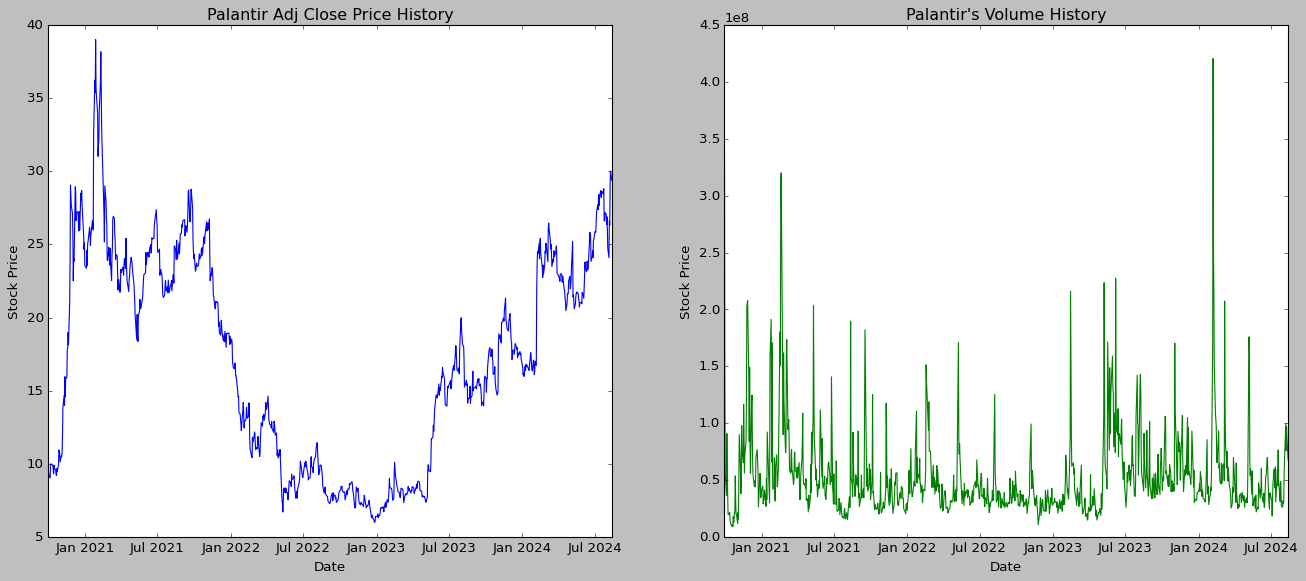

In [299]:
# First plot
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
ax1.plot(pltr2["ds"], pltr2["y"])
ax1.set_xlabel("Date", fontsize=12)
ax1.set_ylabel("Stock Price")
ax1.set_title("Palantir Adj Close Price History")

# Second plot
ax2.plot(pltr["Date"], pltr["Volume"], color="green")
ax2.set_xlabel("Date", fontsize=12)
ax2.set_ylabel("Stock Price")
ax2.set_title("Palantir's Volume History")
plt.show()

4. Add Chart indicators, also known as Regressors (optional)

In [300]:
pltr['SMA_50'] = pltr['Close'].rolling(window=50).mean()
pltr['SMA_200'] = pltr['Close'].rolling(window=200).mean()
pltr['ma50'] = pltr['Close'].rolling(window=50).mean()
pltr['ma200'] = pltr['Adj Close'].rolling(window=200).mean()
pltr['Volume'] = pltr['Volume']
pltr_indc = pltr.dropna()
pltr_indc

,Date,Open,High,Low,Close,Adj Close,Volume,ds,y,SMA_50,SMA_200,ma50,ma200
199,2021-07-16,21.600000,21.709999,21.240000,21.370001,21.370001,19503100,2021-07-16,21.370001,23.1150,22.68605,23.1150,22.68605
200,2021-07-19,20.969999,21.690001,20.549999,21.540001,21.540001,30314400,2021-07-19,21.540001,23.1440,22.74625,23.1440,22.74625
201,2021-07-20,21.629999,22.350000,21.219999,22.180000,22.180000,22954000,2021-07-20,22.180000,23.1926,22.80985,23.1926,22.80985
202,2021-07-21,22.270000,22.680000,22.120001,22.520000,22.520000,20437300,2021-07-21,22.520000,23.2736,22.87645,23.2736,22.87645
203,2021-07-22,22.549999,22.670000,21.879999,22.070000,22.070000,17468900,2021-07-22,22.070000,23.3108,22.94165,23.3108,22.94165
...,...,...,...,...,...,...,...,...,...,...,...,...,...
967,2024-08-06,27.049999,27.420000,25.570000,26.590000,26.590000,99622700,2024-08-06,26.590000,25.3480,21.63460,25.3480,21.63460
968,2024-08-07,27.070000,28.360001,26.240000,26.320000,26.320000,75975400,2024-08-07,26.320000,25.4542,21.68090,25.4542,21.68090
969,2024-08-08,27.040001,29.375000,26.690001,29.280001,29.280001,96892900,2024-08-08,29.280001,25.6188,21.74675,25.6188,21.74675
970,2024-08-09,29.280001,30.360001,29.100000,30.010000,30.010000,88131100,2024-08-09,30.010000,25.8002,21.81580,25.8002,21.81580


In [301]:
# Calculate Relative Strength Index (RSI)
def RSI(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

In [302]:
# Calculate VWAP (Volume Weighted Average Price)
def VWAP(bac):
    q = pltr['Volume']
    p = pltr['Close']
    vwap = (p * q).cumsum() / q.cumsum()
    return vwap

In [303]:
pltr['vwap'] = VWAP(pltr)

In [304]:
# Drop rows with NaN values created by rolling calculations
pltr.dropna(inplace=True)

5. Fit data for the modeling

In [305]:
# insert model
pltr2_model = Prophet()

In [306]:
# fit into model
pltr2_model.fit(pltr2)

19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing


In [307]:
# Create Future dateframe for predictions
pltr_futureprices = pltr2_model.make_future_dataframe(periods=365)


In [308]:
# Create Forcast for Price Prediction 
pltr_forecast = pltr2_model.predict(pltr_futureprices)
pltr_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1332,2025-08-08,40.511249,30.039584,51.850897
1333,2025-08-09,40.092311,29.498897,51.581338
1334,2025-08-10,40.108627,29.615621,51.577660
1335,2025-08-11,40.641859,29.786089,51.663028
1336,2025-08-12,40.628381,29.716436,51.714628


6. Plot Forcast

In [309]:
import matplotlib.dates as mdates

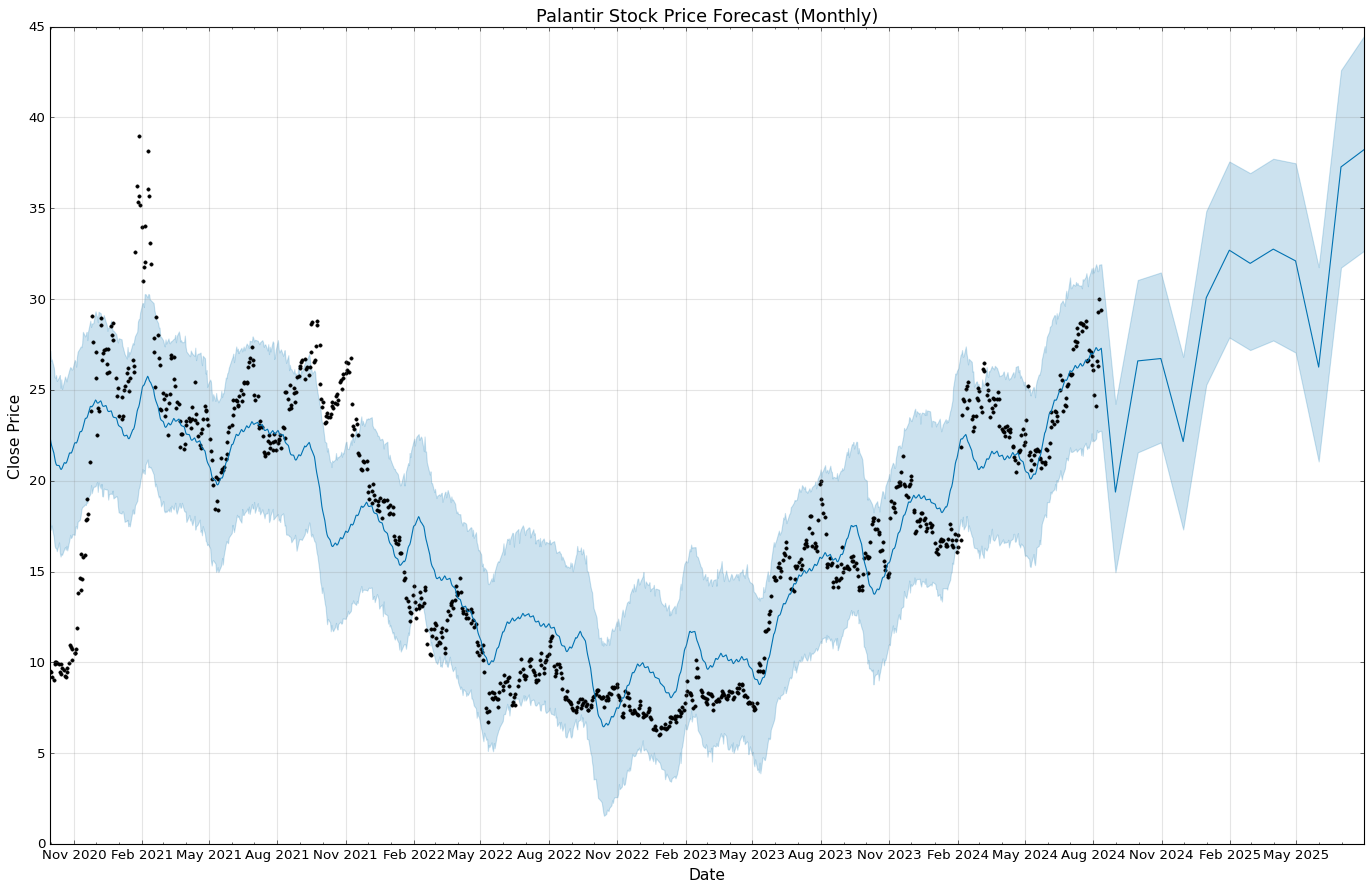

In [324]:
# Plot the forecast 
pltrfig = pltr2_model.plot(pltr_forecast)

# Get current axis
pltrax = pltrfig.gca()

# Set custom labels
pltrax.set_title("Palantir Stock Price Forecast (Monthly)", fontsize=16)
pltrax.set_xlabel("Date", fontsize=14)
pltrax.set_ylabel("Close Price", fontsize=14)

# Set x-axis to show ticks every 3 months
pltrax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Set major ticks to every 3 months
pltrax.xaxis.set_minor_locator(mdates.MonthLocator())  # Optional: Minor ticks for every month
pltrax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Format the date as 'Month Year'

# Expand size of plot
for ax in pltrfig.get_axes():
    ax.figure.set_size_inches(18, 12)  # Width, Height in inches



Reflecting on the above plot: 
- the [black] points are the actual "adj closing price", 
- the [thin dark blue] lines are the models past and future price trend predictions, we can already see its a less confident and detailed prediction as August Approaches. 
- the [light blue] stream is bigger trend margins of the forcast. 

7. Now, lets break down our data and see any trends in months, weeks, and days of the price action. 

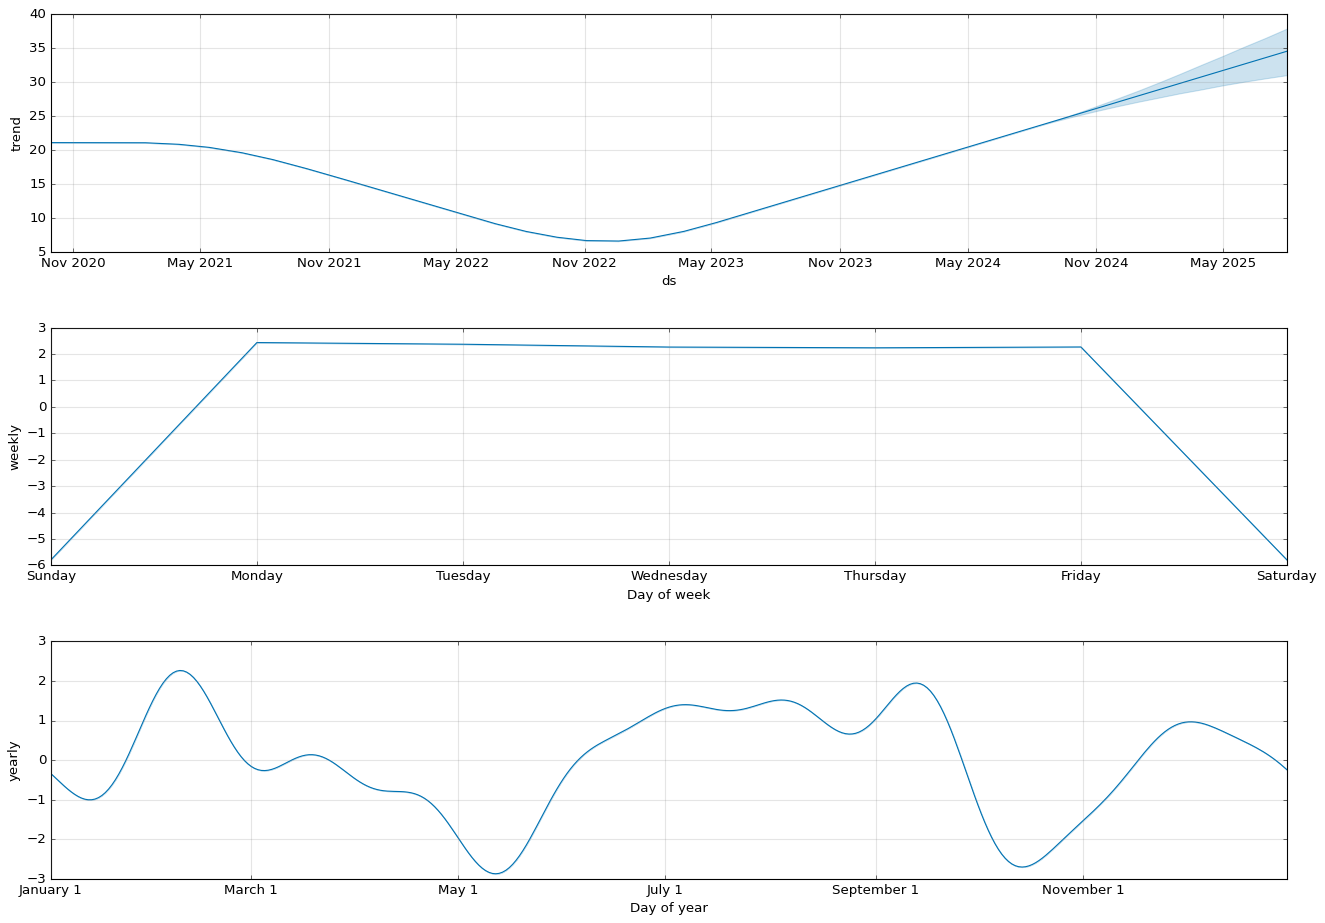

In [327]:
# plot forcast
pltrfig2 = pltr2_model.plot_components(pltr_forecast)

# Expand size of figure
for ax in pltrfig2.get_axes():
    ax.figure.set_size_inches(18, 12)
    
plt.show()


Monthly Predictions

We'll repeat this process by plotting our predictions solely to see the trends by month. 

19:04:48 - cmdstanpy - INFO - Chain [1] start processing
19:04:48 - cmdstanpy - INFO - Chain [1] done processing


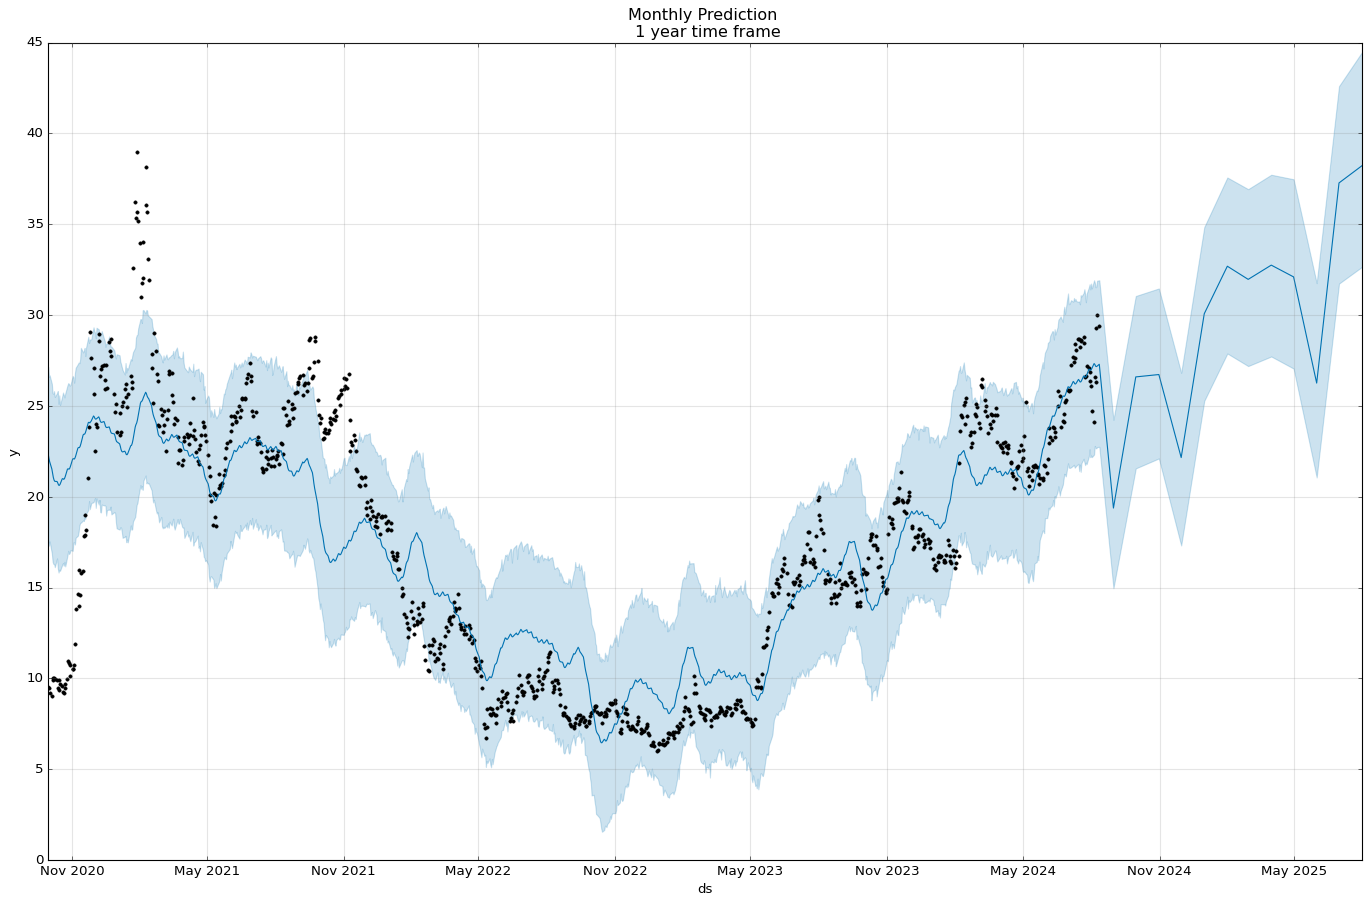

In [312]:
# Monthly Predictions
pltr2_model = Prophet(changepoint_prior_scale=0.01).fit(pltr2)
pltr_futureprices = pltr2_model.make_future_dataframe(periods=12, freq='M')
pltr_forecast = pltr2_model.predict(pltr_futureprices)
pltrfig2 = pltr2_model.plot(pltr_forecast)
plt.title("Monthly Prediction \n 1 year time frame")

# Set custom labels and title
pltrax.set_title("Monthly Prediction \n 1 Year Time Frame", fontsize=16)
pltrax.set_xlabel("Date", fontsize=14)
pltrax.set_ylabel("Close Price", fontsize=14)

# Expand the size of the plot
pltrfig2.set_size_inches(18, 12)

plt.show()

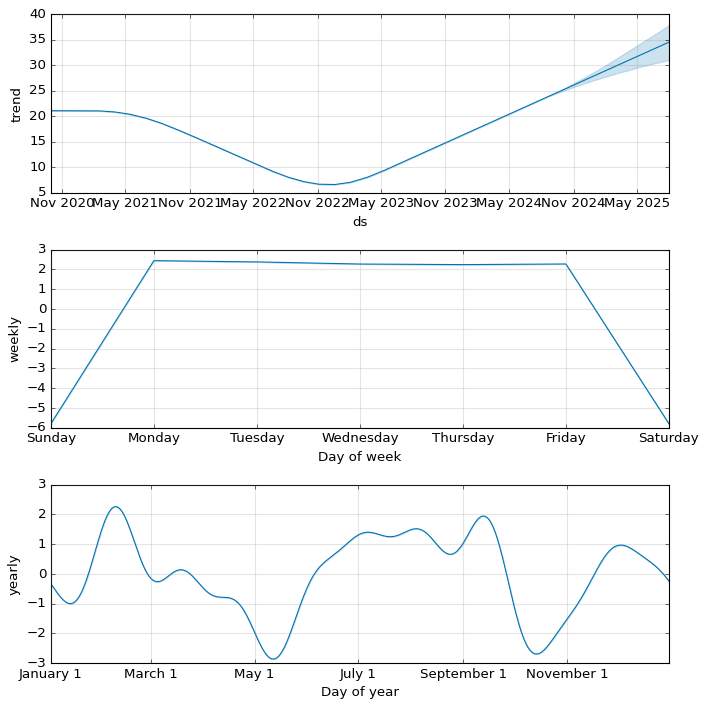

In [313]:
pltrfig3 = pltr2_model.plot_components(pltr_forecast)
plt.show()

Now lets create an interactive plot to be able to view our model in a bit more detail, giving us the ability to zoom in and out of specific areas of our forcast

In [314]:
#import library
import nbformat
print(nbformat.__version__)

5.10.4


In [328]:
#chart an interactive plot of forecast
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(pltr2_model, pltr_forecast)

8. Model Evaluation

Let's use the [Diagnostics](https://facebook.github.io/prophet/docs/diagnostics.html) library from `prophet` to validate our model using `cross_validation`.

In [329]:
#import library
from prophet.diagnostics import cross_validation

Now **create a DataFrame that is the result of running `cross_validation` on our model, with a horizon of 180, 80 or 60 days!

In [ ]:
pltr_validation = cross_validation(pltr2_model, period='60 days', horizon='80 days')

In [318]:
pltr_validation

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2021-10-08,24.554575,22.927981,26.343544,23.500000,2021-10-07
1,2021-10-11,24.652985,22.801704,26.301871,23.530001,2021-10-07
2,2021-10-12,24.528594,22.876261,26.166578,23.690001,2021-10-07
3,2021-10-13,24.465197,22.801664,26.091574,24.129999,2021-10-07
4,2021-10-14,24.291364,22.586620,25.915801,24.350000,2021-10-07
...,...,...,...,...,...,...
929,2024-08-06,27.260976,22.228723,32.414821,26.590000,2024-05-24
930,2024-08-07,27.178092,22.145822,32.159883,26.320000,2024-05-24
931,2024-08-08,27.117714,22.295470,32.027302,29.280001,2024-05-24
932,2024-08-09,27.147832,22.606004,32.043283,30.010000,2024-05-24


9. Interpretation

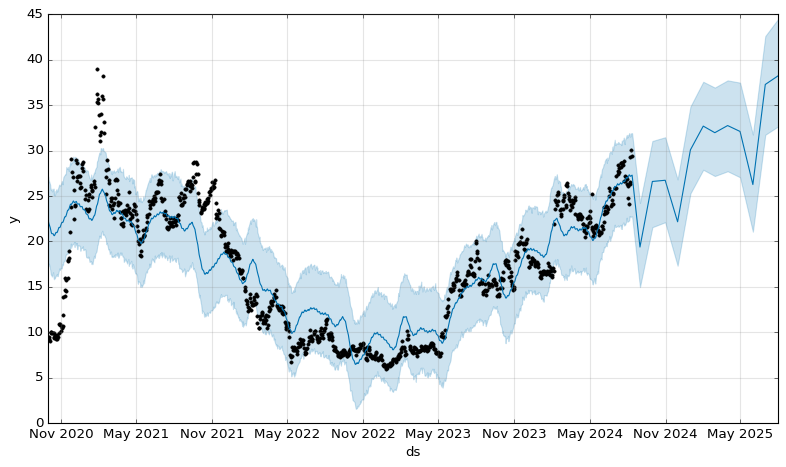

In [319]:
pltr2_model.plot(pltr_forecast);

* We can see from the prediction `plot` that we have a point after which the model quickly starts to lose confidence.
* We can also see the same from the errors - as we try to predict further into the future, our accuracy goes down.

**Finally, let's visualize the errors** (differences) that between our model prediction and the seen reality. We will use the `mae` (Mean Absolute Error) as the metric. 


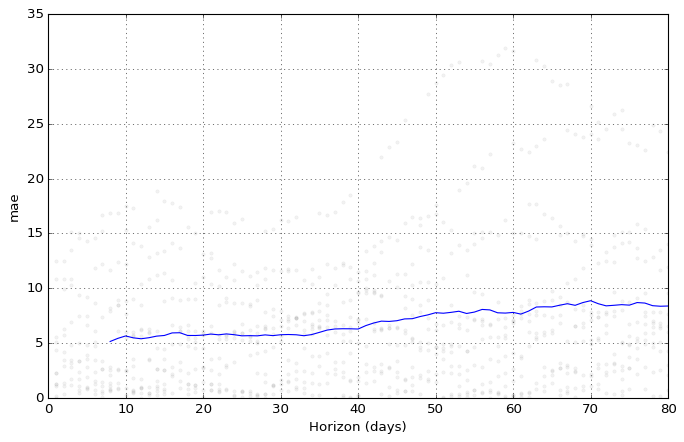

In [320]:
from prophet.plot import plot_cross_validation_metric
pltr2 = plot_cross_validation_metric(pltr_validation, metric='mae')

**Our best case interpretation:**

We can see some clear highs and lows in our errors. The further out we predict in days, the more our mae increases, implying our accuracy will be less. we see our volitalty for accuracy also increases. 

The **volatility** (waviness) or errors are fairly stable with some certainty. 